### Fit the following logarithmic equation to a set of 50 (x,y) data points:

y=a⋅log(x)+b

### Load and plot the data

### Find most frequent ingredients.

In [17]:
# Import neccessary libraries 
import pandas as pd 
import numpy as np 
import numpy.polynomial.polynomial as poly 
import matplotlib.pyplot as plt 
%matplotlib inline

# Load the data for that task, check first entries
df = pd.read_csv("p3_task-1.csv")
df.head()

,x,y
0,10.529,39.105
1,10.799,40.584
2,11.698,39.883
3,12.851,39.411
4,13.565,40.760


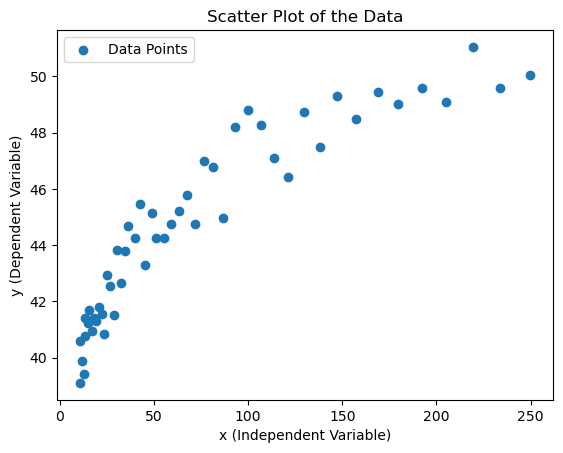

In [19]:
# Extract the x and y data from the dataset
x = df.x
y = df.y

# Create a scatter plot to show the relationship between x and y
plt.scatter(x, y, label="Data Points")

# Add title and axis labels to the plot
plt.title("Scatter Plot of the Data")
plt.xlabel("x (Independent Variable)")
plt.ylabel("y (Dependent Variable)")

# Show the plot
plt.legend()
plt.show()

------
#### Define a new variable log(x) and transform the data.
#### Fit a model to the new data.
#### Plot the logarithmic curve against the original data.

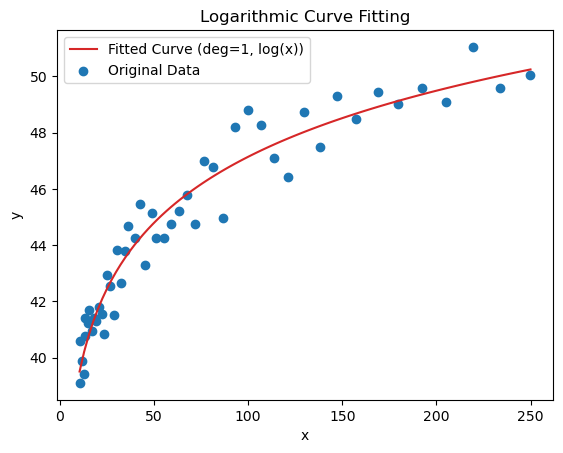

In [14]:
# Compute the natural logarithm of x values to change the input data
log_x = np.log(x)

# Fit a first degree polynomial to the changed data
coefs = poly.polyfit(log_x, y, deg=1)

# Generate 100 values showing the range of x
x_values = np.linspace(x.min(), x.max(), num=100)

# Predict y values from generated x-values using the fitted polynomial
y_pred = poly.polyval(np.log(x_values), coefs)

# Predict y-values from all the data points using the fitted polynomial
y_pred_values = poly.polyval(log_x, coefs)

# Create a scatter plot of the original data and add the curve
plt.scatter(x, y, label="Original Data")
plt.plot(x_values, y_pred, c="C3", label="Fitted Curve (deg=1, log(x))")
plt.title("Logarithmic Curve Fitting")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

#### My observations:

- The data follows a logarithmic trend as \(x\) increases.
- The curve closely matches the pattern of the original data, which indicates for a good fit.
- There is an increasing trend in that dataset.

---
### Compute the RSS and $R^2$ measures.

In [21]:
from sklearn.metrics import r2_score

# Define a function to compute the Residual Sum of Squares (RSS)
def RSS(y, y_pred):
    return np.sum(np.square(np.subtract(y, y_pred)))

# Calculate and show the RSS and R^2 score
rss_score = RSS(y, y_pred_values)
r2 = r2_score(y, y_pred_values)

print("Residual Sum of Squares (RSS): {:.2f}".format(rss_score))
print("Coefficient of Determination (R^2 Score): {:.2f}".format(r2))

Residual Sum of Squares (RSS): 31.84
Coefficient of Determination (R^2 Score): 0.94


---
### Is it a good $R^2$ score?

- The model explains **94% of the patterns** in the data, which shows it does a good job of predicting the results.

- Only **6% of the data** is not explained by the model, meaning there are small factors or noise that the model didn't notice.

- An R^2 score of **0.94** is very close to 1, which is almost perfect. This shows the model fits the data really well.

- In general, the model works very well and gives accurate predictions.
---


### Fit models to data with outliers and compare three approaches:

1. Linear regression with outliers.
2. Huber regression with outliers.
3. Linear regression without outliers.

#### Split the data into train (80%) and test (20%) sets.

In [29]:
# Load data and show first rows
df2 = pd.read_csv("p3_task-2.csv")
df2.head()

,x1,x2,x3,y
0,7.892,318.818,162.970,2112.420
1,8.830,303.180,181.399,2096.231
2,13.811,296.231,145.849,2067.045
3,12.863,325.830,167.996,2269.262
4,13.698,254.035,171.892,1966.604


In [57]:
from sklearn.model_selection import train_test_split

# Extract feature columns (x1, x2, x3) and the target column y from the dataset
x2 = df2.iloc[:, :3]  # Features: first 3 columns
y2 = df2.y  # Target variable: last column

# divide the dataset into training (80%) and testing (20%) sets
# x_tr, y_tr: training features and target
# x_te, y_te: testing features and target
x_tr, x_te, y_tr, y_te = train_test_split(x2, y2, test_size=0.2, random_state=0) # with random_state=0 I keep the split the same every time (for comparison)

---
#### Plot the training data for a quick overview.

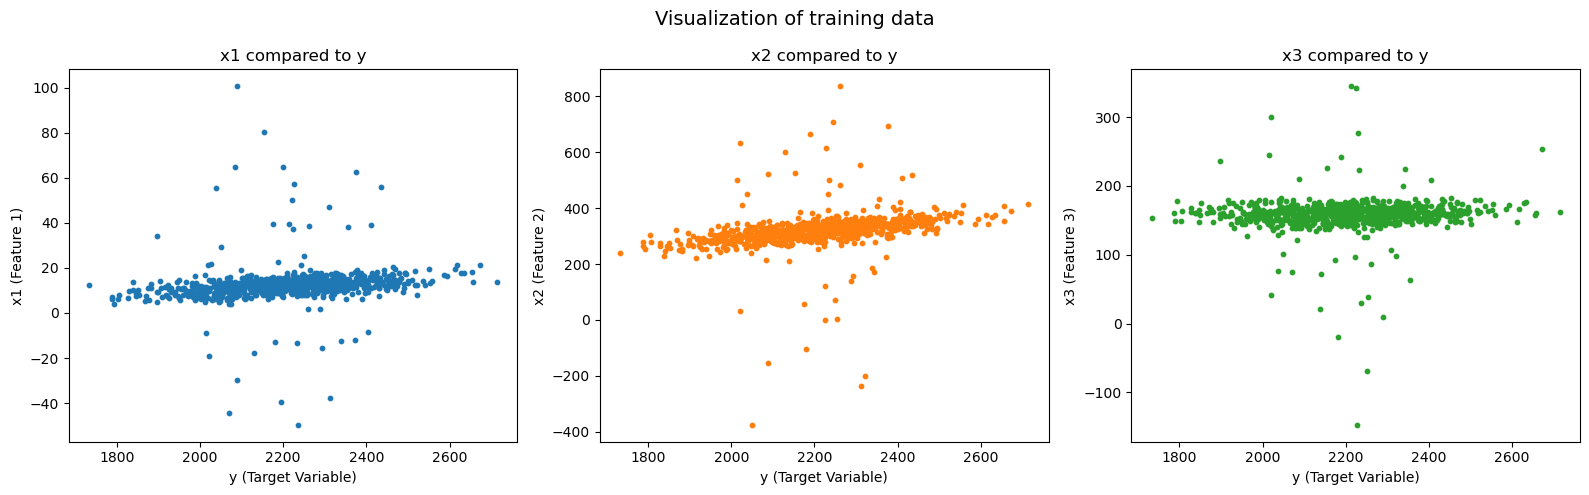

In [59]:
# Create subplots to visualize each feature (x1, x2, x3) against the target variable (y)
fig, axes = plt.subplots(1, 3, figsize=(16, 5)) # 1 row and 3 columns, size of my choice

# with that function I can loop through each feature (x1, x2, x3)
for n, ax in zip(range(3), axes.ravel()): # with range(3) I make numbers 0, 1, and 2 for the three features (x1, x2, x3), ravel - turns all subplots into a simple list and the whole function matches each feature with one subplot
    ax.scatter(y_tr, x_tr.iloc[:, n:n +1], c="C" + str(n), s=10) # I pick the nth feature for the y-axis, the slicing keep the data as a dataframe and with C each feature gets another color
    ax.set(
        xlabel="y (Target Variable)",
        ylabel=f"x{n+1} (Feature {n+1})", # I name the y-axis for each next feature
        title="x" + str(n + 1) + " compared to y"  # same way as above
    )

plt.suptitle("Visualization of training data", fontsize=14)
plt.tight_layout()
plt.show()

In [66]:
# print the shape of training data for an overview
print("Train features shape (with outliers):", x_tr.shape)
print("Train labels shape (with outliers):", y_tr.shape)

Train features shape (with outliers): (800, 3)
Train labels shape (with outliers): (800,)


#### My observations:
- We have 800 rows of training data (800 examples), and each example has 3 features.
- We have 800 target values (one for each example).
- The target values are the answers the model is trying to predict.

---
#### Clean the training data to remove outliers.

In [69]:
# reset the row numbering for both features and target data to keep it neat
x_tr2, y_tr2 = x_tr.reset_index(drop=True), y_tr.reset_index(drop=True)

# I need to define the allowed value ranges for each feature
range_values = {
    "x1": [0, 20],
    "x2": [200, 400],
    "x3": [100, 200]
} 

# chech  each feature and remove values outside the allowed range
for col in range_values:
    # define the range for a feature
    num = range_values.get(col)
    # which values are in the range? use masking operation to show only rows I want to keep
    mask = x_tr2[col].between(num[0], num[1])
    x_tr2 = x_tr2[mask]  # Keep  the rows with valid feature values
    y_tr2 = y_tr2[mask]  # Keep the target values which matches

print("Train features shape (without outliers):", x_tr2.shape)
print("Train labels shape (without outliers):", y_tr2.shape)

Train features shape (without outliers): (746, 3)
Train labels shape (without outliers): (746,)


### My observations:

- We now have 746 rows of training data (746 examples), and each example has 3 features.
- We have 746 target values (one for each example).
- The target values are the answers the model is trying to predict.
- I removed the outliers, which reduced the dataset from 800 to 746 examples.
---

#### Compare the test MAE scores for all three models and comment on the results.

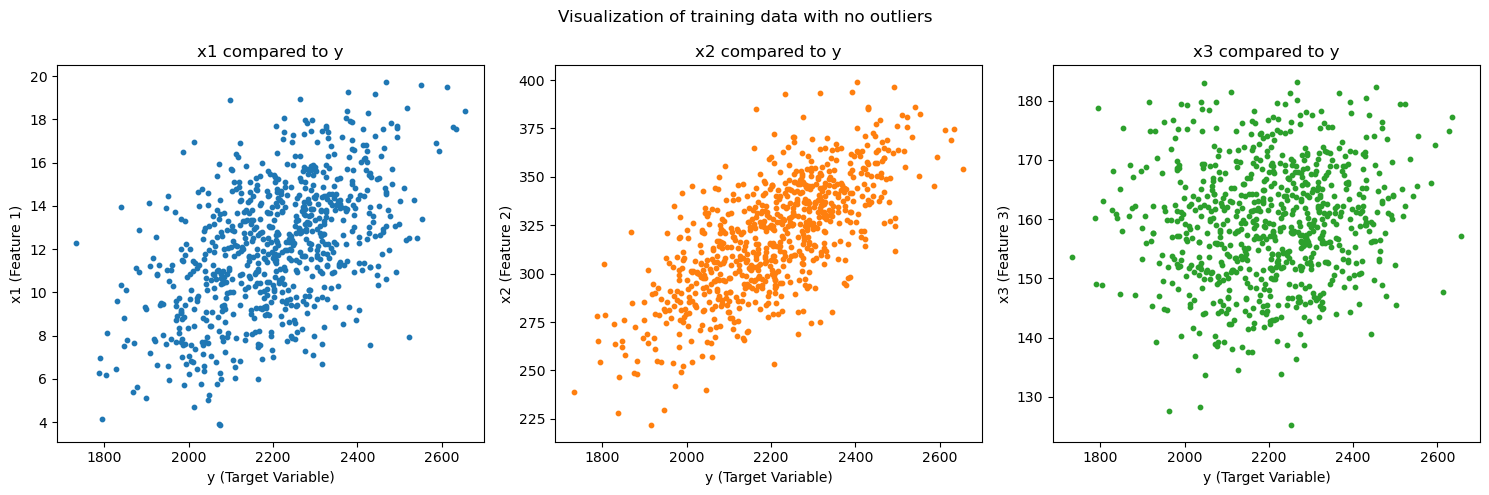

In [72]:
# Create plots with 1 row and 3 columns presented on 3 scatter plots (no outliers)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# looping through each feature as in the examples with outliers, this time no outliers
for n, ax in zip(range(3), axes.ravel()):
    ax.scatter(y_tr2, X_tr2.iloc[:, n:n +1], c="C" + str(n), s=10)
    ax.set(
        xlabel="y (Target Variable)",
        ylabel=f"x{n+1} (Feature {n+1})",
        title="x" + str(n + 1) + " compared to y"  
    )

plt.suptitle("Visualization of training data with no outliers")
plt.tight_layout()
plt.show()

### My observations:

- After removing outliers we have 746 rows of training data (target values) and 3 features.
- the new plots show a better representation of the relationship between the features (`x1`, `x2`, `x3`) and the target (`y`).
- Each feature shows a pattern when compared to the target:
  - **x1 compared to y**: positive linear relationship.
  - **x2 compared to y**: strong positive linear relationship.
  - **x3 compared to y**: slightly weaker relationship with more scattered points.
---

In [75]:
# load necessary libraries needed for linear and huber regression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import LinearRegression, HuberRegressor

# I need to set up 3 models to compare:
# 1. linear regression with outliers
lr =  LinearRegression()
# 2.luber regression as it handles outliers better
huber = HuberRegressor()
# 3. linear regression without outliers
lr_no = LinearRegression()

# now each model needs to be fit to the training data
lr.fit(x_tr, y_tr) # linear regresion with outliers
huber.fit(x_tr, y_tr) # huber regression with outliers
lr_no.fit(x_tr2, y_tr2) # linear regression without outliers

# Display the results for each regression for comparison
print("MAE for linear regression with outliers: {:.3f}".format(MAE(y_te, lr.predict(x_te))))
print("MAE for huber regression with outliers: {:.3f}".format(MAE(y_te, huber.predict(x_te))))
print("MAE for linear regression without outliers: {:.3f}".format(MAE(y_te, lr_no.predict(x_te))))

MAE for linear regression with outliers: 104.788
MAE for huber regression with outliers: 83.908
MAE for linear regression without outliers: 70.616


### My observations:

- **Linear regression with outliers** has the highest error (MAE = 104.788). This shows outliers negatively impact how the model works.
- **Huber regression with outliers** works better (MAE = 83.908) because it is more effective to handle outliers.
- **Linear regression without outliers** has the lowest error (MAE = 70.616). By removing outliers I made the model works better, predicting more accurately.
As expected, using huber regression or removing outliers is more effective if it goes about better predictions.